In [21]:
import json
import os
from dotenv import load_dotenv
from pinecone import Pinecone, ServerlessSpec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Callable, Optional, Iterable
from abc import ABC, abstractmethod
import logging
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain.text_splitter import CharacterTextSplitter
import random
import uuid
import re

In [22]:
# Prompt the user to enter the chunk size
chunk_size_param = int(input("Size of chunks: "))

# Read data

In [23]:
transformer_json = pd.read_json("json_data/transformer.json")

In [24]:
def remove_single_newlines(text: str) -> str:
    # Use a regular expression to replace single newlines with nothing,
    # but keep multiple newlines intact.
    text = re.sub(r'(?<!\n)\n(?!\n)', '', text)
    return text

for text in transformer_json["train"]["text"]:
    text = remove_single_newlines(text)

In [25]:
type(transformer_json["train"]["text"])

list

# Prepare data

Min length: 0
Max length: 33372
Mean length: 8536.148423005567


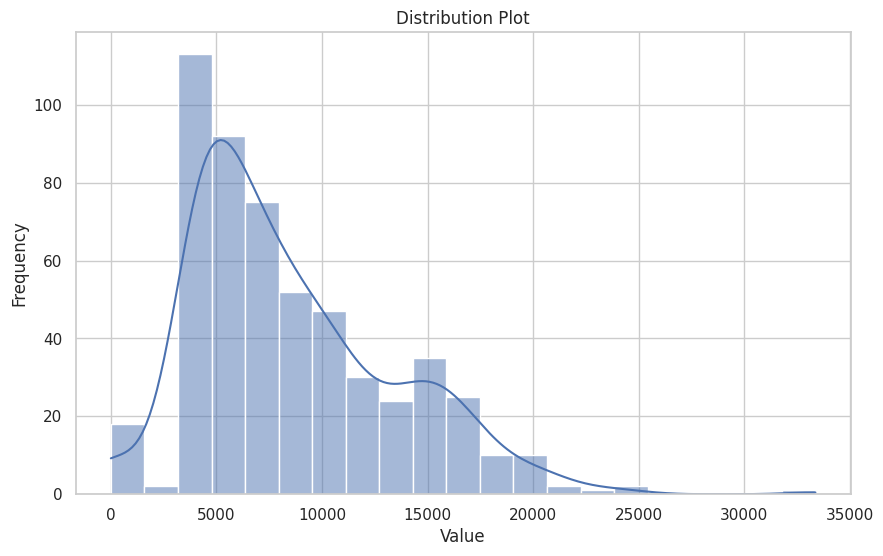

In [26]:
# check the data
list_text = []

for text in transformer_json["train"]["text"]:
    list_text.append(len(text))


print(f"Min length: {min(list_text)}")
print(f"Max length: {max(list_text)}")
print(f"Mean length: {sum(list_text) / len(list_text)}")

# Create the distribution plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(list_text, kde=True)

# Customize the plot
plt.title('Distribution Plot')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## remove len(text) == 0 and split text into chunks

In [27]:
logger = logging.getLogger(__name__)

class BaseDocumentTransformer:
    # Dummy base class to match the structure
    pass

class TextSplitter(BaseDocumentTransformer, ABC):
    """Interface for splitting text into chunks."""

    def __init__(
        self,
        chunk_size: int = 4000,
        chunk_overlap: int = 200,
        length_function: Callable[[str], int] = len,
        keep_separator: bool = False,
        add_start_index: bool = False,
        strip_whitespace: bool = True,
    ) -> None:
        """Create a new TextSplitter.
        Args:
            chunk_size: Maximum size of chunks to return
            chunk_overlap: Overlap in characters between chunks
            length_function: Function that measures the length of given chunks
            keep_separator: Whether to keep the separator in the chunks
            add_start_index: If True, includes chunk's start index in metadata
            strip_whitespace: If True, strips whitespace from the start and end of
                              every document
        """
        if chunk_overlap > chunk_size:
            raise ValueError(
                f"Got a larger chunk overlap ({chunk_overlap}) than chunk size "
                f"({chunk_size}), should be smaller."
            )
        self._chunk_size = chunk_size
        self._chunk_overlap = chunk_overlap
        self._length_function = length_function
        self._keep_separator = keep_separator
        self._add_start_index = add_start_index
        self._strip_whitespace = strip_whitespace

    @abstractmethod
    def split_text(self, text: str) -> List[str]:
        """Split text into multiple components."""
        pass

    def _join_docs(self, docs: List[str], separator: str) -> Optional[str]:
        text = separator.join(docs)
        if self._strip_whitespace:
            text = text.strip()
        if text == "":
            return None
        else:
            return text
    
    def _merge_splits(self, splits: Iterable[str], separator: str) -> List[str]:
        # We now want to combine these smaller pieces into medium size
        # chunks to send to the LLM.
        separator_len = self._length_function(separator)
        docs = []
        current_doc: List[str] = []
        total = 0

        for d in splits:
            _len = self._length_function(d)
            if (
                total + _len + (separator_len if len(current_doc) > 0 else 0)
                > self._chunk_size
            ):
                if total > self._chunk_size:
                    logger.warning(
                        f"Created a chunk of size {total}, "
                        f"which is longer than the specified {self._chunk_size}"
                    )
                if len(current_doc) > 0:
                    doc = self._join_docs(current_doc, separator)
                    if doc is not None:
                        docs.append(doc)
                # Keep on popping if:
                # - we have a larger chunk than in the chunk overlap
                # - or if we still have any chunks and the length is long
                while total > self._chunk_overlap or (
                    total + _len + (separator_len if len(current_doc) > 0 else 0)
                    > self._chunk_size
                    and total > 0
                ):
                    total -= self._length_function(current_doc[0]) + (
                        separator_len if len(current_doc) > 1 else 0
                    )
                    current_doc = current_doc[1:]

            current_doc.append(d)
            total += _len + (separator_len if len(current_doc) > 1 else 0)

        doc = self._join_docs(current_doc, separator)
        if doc is not None:
            docs.append(doc)

        return docs

class NewlineTextSplitter(TextSplitter):
    def split_text(self, text: str, prefix: str = "") -> List[str]:
        prefix_len = len(prefix)
        if (len(text) + prefix_len) <= self._chunk_size:
            return [prefix + text]
        
        lines = text.split('\n\n\n')
        splits = []
        
        for line in lines:
            # Check if the current line exceeds the chunk size
            if (len(line) + prefix_len) > self._chunk_size:
                # If the line itself is too long, split it into smaller chunks
                start = 0
                while start < len(line):
                    end = start + self._chunk_size + prefix_len
                    splits.append(prefix + line[start:end])
                    start = end
            else:
                # Add line to splits
                splits.append(prefix + line)
        
        return splits

# Function to concatenate information into a single document
def create_document(transformer):
    name = "Name: " + ", ".join(transformer["name"])
    category = "Category: " + ", ".join(transformer["category"])
    description = "Description: " + transformer["text"]
    related_transformers = "Related Transformers: " + ", ".join(transformer["related_transformers"])

    document = f"{name}\n{category}\n{description}\n{related_transformers}"
    return document

# Function to process JSON data
def process_json_data(data, splitter):
    processed_data = {}
    
    for name, category, text, related in zip(data["name"], data["category"], data["text"], data["related_transformers"]):
        list_split_text = []
        text_complete = f"Name: {name} Category: {category} Description: {text}"
        additional = f"Name: {name} Category: {category} Description: "
        if len(text_complete) >= splitter._chunk_size:
            split_texts = splitter.split_text(text, additional)

            for text_splitter in split_texts:
                document = create_document({
                    "name": [name],
                    "category": [category],
                    "text": text_splitter,
                    "related_transformers": [related]
                })
                list_split_text.append(document)
        else:
            document = create_document({
                "name": [name],
                "category": [category],
                "text": text,
                "related_transformers": [related]
            })
            list_split_text.append(document)


        processed_data[name] = list_split_text

    return processed_data

# Example usage
splitter = NewlineTextSplitter(chunk_size=chunk_size_param)

# Process the data
processed_data = process_json_data(transformer_json['train'], splitter)

Min length: 66
Max length: 2654
Mean length: 1578.5375840889149


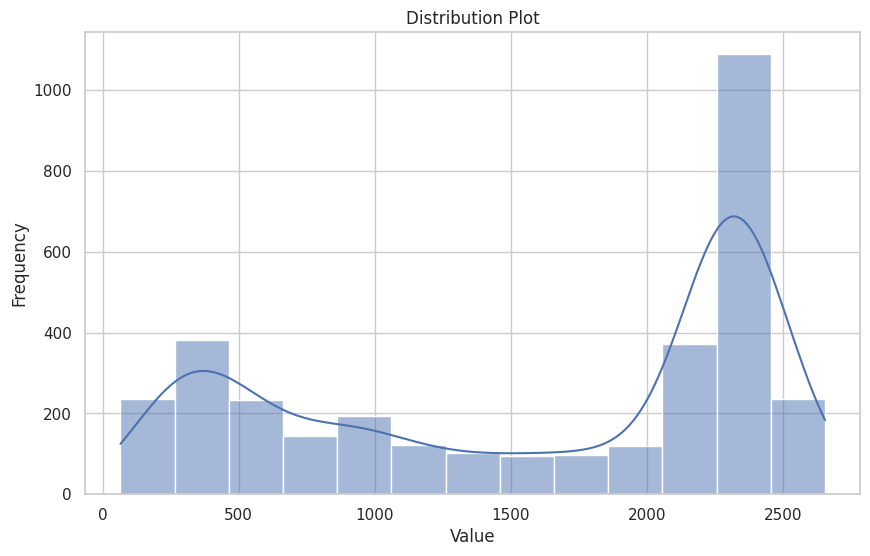

In [28]:
# check the data
list_text = []
keys = processed_data.keys()

for key in keys:
    for elements in processed_data[key]:
        list_text.append(len(elements))


print(f"Min length: {min(list_text)}")
print(f"Max length: {max(list_text)}")
print(f"Mean length: {sum(list_text) / len(list_text)}")

# Create the distribution plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(list_text, kde=True)

# Customize the plot
plt.title('Distribution Plot')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Add ID to each text item

In [29]:
# Function to generate unique ID
def generate_unique_id():
    return str(uuid.uuid4())

# Create a new dictionary to store the result
result = []

# Iterate through the data and assign unique IDs
for key, texts in processed_data.items():
    for text in texts:
        unique_id = generate_unique_id()
        reslt_json = {"id": unique_id, "text": text}
        result.append(reslt_json)

# Vectore store

In [30]:
# Load environment variables from .env file
load_dotenv()
pinecone_api_key = os.getenv("API_KEY")

# Initialize Pinecone
pc = Pinecone(api_key=pinecone_api_key)
index_name = f"rag-example-{chunk_size_param}"

# Get the list of indexes
indexes_response = pc.list_indexes()

# Extract the list of indexes
indexes = indexes_response.get('indexes', [])

# Check if the index exists
if not any(index['name'] == index_name for index in indexes):
    pc.create_index(index_name,
                    dimension=1024,
                    spec=ServerlessSpec(
                    cloud="aws",
                    region="us-east-1"
                ) )  # Adjust dimension to match the model output

# Connect to the index
index = pc.Index(index_name)

In [31]:
model_name = "BAAI/bge-m3"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
    query_instruction = "search_query:",
    embed_instruction = "search_document:"
)

/home/codespace/.python/current/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [32]:
random.seed(42)

samples = random.sample(result, 250)

In [33]:
embedded_vectors = []
df = pd.DataFrame(columns=["id", "text", "vector"])
df_text = pd.DataFrame(columns=["id", "text"])
for element in samples:
    vector = hf.embed_query(element["text"])
    embedded_json = {"id": element["id"],"values": vector}
    embedded_vectors.append(embedded_json)
    new_row = pd.DataFrame({"id": [element["id"]], "text": [element["text"]], "vector": [vector]})
    text_token = f"<start>{[element['text']]}<eos>"
    new_row_text = pd.DataFrame({"id": [element["id"]], "text": text_token, "vector": [vector]})
    df = pd.concat([df, new_row], ignore_index=True)
    df_text = pd.concat([df, new_row_text], ignore_index=True)

In [34]:
df.to_csv(f"tokens/output_{chunk_size_param}.csv", index=False, sep=";")
df_text.to_csv(f"tokens/output_{chunk_size_param}_without_vec.csv", columns=["id", "text"], sep=";")

In [35]:
len(embedded_vectors[0]["values"])

1024

In [36]:
index.upsert(
  vectors=embedded_vectors
)

{'upserted_count': 250}